In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy import signal

# SIMULACIÓN DEL SEGMENTO 0, MODO 2

In [2]:
mapping_table = {
    (0,0,0,0) : (-3-3j)/np.sqrt(10),
    (0,0,0,1) : (-3-1j)/np.sqrt(10),
    (0,0,1,0) : (-3+3j)/np.sqrt(10),
    (0,0,1,1) : (-3+1j)/np.sqrt(10),
    (0,1,0,0) : (-1-3j)/np.sqrt(10),
    (0,1,0,1) : (-1-1j)/np.sqrt(10),
    (0,1,1,0) : (-1+3j)/np.sqrt(10),
    (0,1,1,1) : (-1+1j)/np.sqrt(10),
    (1,0,0,0) :  (3-3j)/np.sqrt(10),
    (1,0,0,1) :  (3-1j)/np.sqrt(10),
    (1,0,1,0) :  (3+3j)/np.sqrt(10),
    (1,0,1,1) :  (3+1j)/np.sqrt(10),
    (1,1,0,0) :  (1-3j)/np.sqrt(10),
    (1,1,0,1) :  (1-1j)/np.sqrt(10),
    (1,1,1,0) :  (1+3j)/np.sqrt(10),
    (1,1,1,1) :  (1+1j)/np.sqrt(10)
}

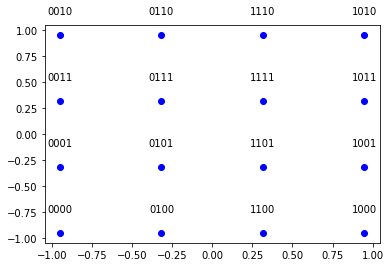

In [3]:
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

In [4]:
demapping_table = {v : k for k, v in mapping_table.items()}

In [5]:
K = 217 # numero de portadoras OFDM 
CP = K//4  # duracion del prefijo ciclico
P = 18 # numero de portadoras piloto
pilotValue = (3+3j)/np.sqrt(10) # valor del piloto...que es conocido por el receptor
allCarriers = np.arange(K)  # subportadoras ([0, 1, ... K-1])
fs=8.126 #
ts=1/fs
t=np.linspace(0,ts*K,K+CP)  # nuestro futuro eje de tiempos

pilotCarriers = allCarriers[:K:K//(P)] # pilotos cada (K/P) 

# las pimer y ultima portadora las hacemos piloto

# tenemos el TMCC, AC, QUE SON DE INFORMACION DE CONTROL
control=np.array([23,98,101,118,136,178])
pilotCarriers = np.hstack([pilotCarriers, control])
pilotCarriers = np.sort(pilotCarriers)

# el resto de las portadoras seran de dato
dataCarriers = np.delete(allCarriers, pilotCarriers)


Como TMCC y AC1 son portadoras de datos de control, que no conocemos, le pondremos el valor de una pilot carrier SP

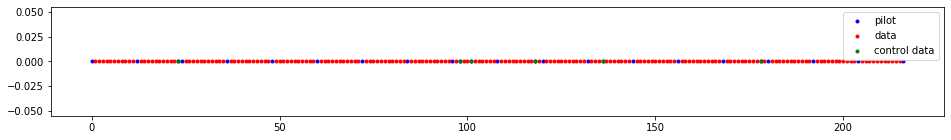

In [6]:
plt.figure(figsize=(16,2))
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'b.', label='pilot')
plt.legend(fontsize=10)
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'r.', label='data')
plt.legend(fontsize=10)
plt.plot(control, np.zeros_like(control), 'g.', label='control data')
plt.legend(fontsize=10)
pilotCarriers = np.hstack([pilotCarriers, control])
pilotCarriers = np.sort(pilotCarriers)

In [7]:
## Payload del simbolo OFDM

mu = 4 # bits por simbolo (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # numero de bits de datos por simbolo ofdm


/home/hondu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


18

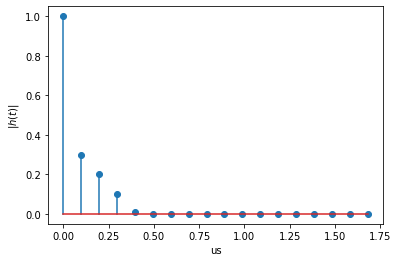

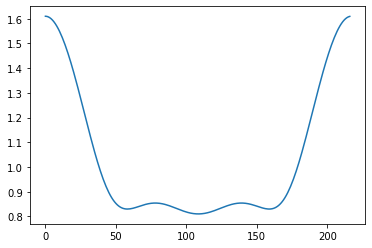

In [8]:
#CREAMOS UN CANAL CON RUIDO

channelResponse = np.array([1,0.3,0.2,0.1,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0])  # Respuesta al impulso del canal de comunicaciones
plt.figure() ;plt.stem(t[0:len(channelResponse)],np.abs(channelResponse))
plt.xlabel('us'); plt.ylabel('$|h(t)|$');
H_exact = np.fft.fft(channelResponse, K)
plt.figure(); plt.plot(allCarriers, abs(H_exact))
SNRdb = 400  # signal to noise-ratio dB 
len(channelResponse)

In [9]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))

print ("N° de bits: ", len(bits))
print ("Ej. de los 20 primeros: ", bits[:20])
print ("media: ", np.mean(bits))

N° de bits:  768
Ej. de los 20 primeros:  [0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1]
media:  0.4921875


Notemos que la cantidad de bits, corresponde a las 96 portadoras de datos, por la cantidad de simbolos portadora, y si tomamos un esquema de punteo de 1/2, cada 16 bits pertenecerian a un TSP.

Si tenemos 384 bits divididos los 16 bits de cada TSP, entonces la cantidad de TSP por cada simbolo ODFM serian 24, lo cual correspone con las tablas.

In [10]:
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) #  K subcarriers
    symbol[pilotCarriers] = pilotValue  #  pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  #  pilot subcarriers
    return symbol

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               #  CP samples ...
    return np.hstack([cp, OFDM_time])  # ... al principio

def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # Calcula la potencia de ruido en base al SNR
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Genero el ruido a partir de la varianza obtenida
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

def removeCP(signal):
    return signal[CP:(CP+K)]

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # Extraigo el piloto de la senal recibida
    Hest_at_pilots = pilots / pilotValue # Divido por el valor de los pilotos transmitidos
    # hago una interpolacion entre las portadoras piloto estimadas por el canal sobre las portadoras de datos
    Hest_abs = interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Canal')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Piloto estimado')
    plt.plot(allCarriers, abs(Hest), label='Estimacion del canal por interpolación')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    return Hest

def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

def get_payload(equalized):
    return equalized[dataCarriers]

def Demapping(QAM):
    constellation = np.array([x for x in demapping_table.keys()]) # los puntos de la constelación
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1))) # Calcula la distacia entre los puntos y la constelacion
    const_index = dists.argmin(axis=1) # para cada punto de QAM, elijo en indice en la constelacion que pertenece al simbolo mas cercano 
    hardDecision = constellation[const_index] # punto real de la constelacion
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision # transformo la constelación en bists
len(allCarriers[:109:K//(P)])

10

In [11]:
bits_SP = SP(bits)

In [12]:
QAM = Mapping(bits_SP)

In [13]:
OFDM_data = OFDM_symbol(QAM)

In [14]:
OFDM_time = IDFT(OFDM_data)

numero de muestras con CP:  271
271


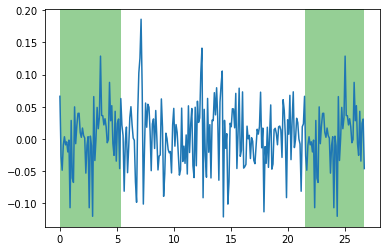

In [15]:
OFDM_withCP = addCP(OFDM_time)
print ("numero de muestras con CP: ", len(OFDM_withCP))

plt.plot(t,OFDM_withCP.real)
plt.axvspan(t[0],t[CP], facecolor='#2ca02c', alpha=0.5)
plt.axvspan(t[K],t[-1], facecolor='#2ca02c', alpha=0.5)
print(len(t))

RX Signal power: 0.0053. Noise power: 0.0000


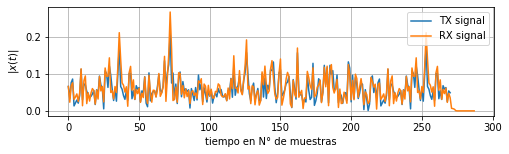

In [16]:
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('tiempo en N° de muestras'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [17]:
# sacamos el prefijo ciclico
OFDM_RX_noCP = removeCP(OFDM_RX)

In [18]:
# la señal es demodulada ahora usando la FFT
OFDM_demod = DFT(OFDM_RX_noCP)

/home/hondu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


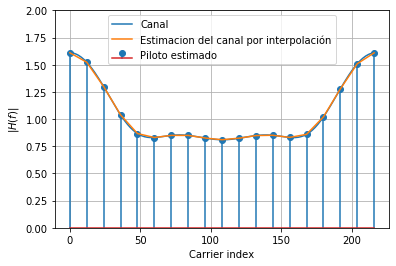

In [19]:
pilotCarriers = allCarriers[:K:K//(P)]
Hest = channelEstimate(OFDM_demod)
pilotCarriers = np.hstack([pilotCarriers, control])
pilotCarriers = np.sort(pilotCarriers)

In [20]:
equalized_Hest = equalize(OFDM_demod, Hest)

In [21]:
np.shape(equalized_Hest)

(217,)

Text(0.5, 1.0, 'CANAL ECUALIZADO VS SIN ECUALIZAR')

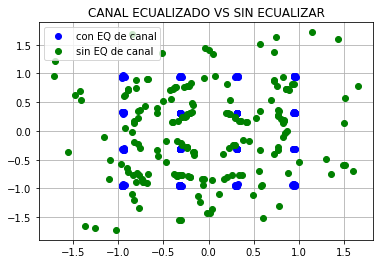

In [22]:
QAM_est = get_payload(equalized_Hest)
QAM_sin_est = get_payload(OFDM_demod)

plt.plot(QAM_est.real, QAM_est.imag, 'bo',label="con EQ de canal");
plt.plot(QAM_sin_est.real, QAM_sin_est.imag, 'go',label="sin EQ de canal");
plt.grid(True); plt.legend(fontsize=10)
plt.title("CANAL ECUALIZADO VS SIN ECUALIZAR")

tomamos una decision de a que simbolo pertence, segun la distancia minima


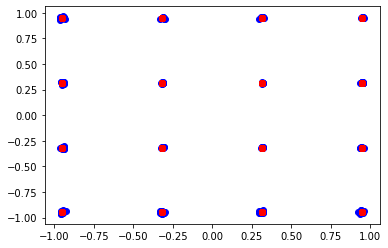

In [23]:
PS_est, hardDecision = Demapping(QAM_est)

for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')

print('tomamos una decision de a que simbolo pertence, segun la distancia minima')

In [24]:
i=1
for bit in QAM_est:
    print("El simbolo No {}".format(i))
    print(bit)
    i=i+1

El simbolo No 1
(-0.3173071400853048+0.31775330191715345j)
El simbolo No 2
(0.3199127373724274+0.9553539822630628j)
El simbolo No 3
(0.9576461050267767-0.3213359321310603j)
El simbolo No 4
(-0.9592497610610362+0.3224378761552085j)
El simbolo No 5
(-0.962051169074318-0.3175533309625068j)
El simbolo No 6
(-0.3215078167480511-0.31945895981749417j)
El simbolo No 7
(-0.9600203564803721+0.32351499009344115j)
El simbolo No 8
(-0.3189813407178044+0.32100830914115913j)
El simbolo No 9
(0.32209105695900336+0.9572937667864725j)
El simbolo No 10
(0.9550066574144913-0.3206572127348203j)
El simbolo No 11
(-0.3187101203608088-0.9521293815138997j)
El simbolo No 12
(0.9522529572486461+0.31437594619749637j)
El simbolo No 13
(0.31951975817704836+0.31611667712781544j)
El simbolo No 14
(-0.320700118873854-0.3159924537800984j)
El simbolo No 15
(-0.327271676488693-0.9532520337926186j)
El simbolo No 16
(-0.3093053498411096+0.9598766877978111j)
El simbolo No 17
(0.3088436593100047-0.9601359934373023j)
El simbo

Para la medicion del PAR, la tenemos que hacer sobre un cuadro ODFM, que esta compuesto por 204 simbolos ODFM

In [25]:
N_of_sym=204


K = 2809# numero de portadoras OFDM 
CP = K//4  # duracion del prefijo ciclico
P = 18*13 # numero de portadoras piloto
pilotValue = (3+3j)/np.sqrt(10) # valor del piloto...que es conocido por el receptor
allCarriers = np.arange(K)  # subportadoras ([0, 1, ... K-1])
fs=8.126 # 8.126MHz de frecuencia de muestreo de la ifft
ts=1/fs
t=np.linspace(0,ts*K,K+CP)  # nuestro futuro eje de tiempos
zeros=int((4096-K+1)/2)
zerosarr=np.zeros(zeros,dtype=complex)

pilotCarriers0 = allCarriers[::K//P] # pilotos cada (K/P) 
pilotCarriers1 = allCarriers[3::K//P]
pilotCarriers2 = allCarriers[6::K//P]
pilotCarriers3 = allCarriers[9::K//P]

frame=np.empty(0)
frame_shapped=np.empty(0)
i=0

IFFTSIZE=4096
CP=int(IFFTSIZE/4)

for sym in range(N_of_sym):
    if i==0:
        pilotCarriers=pilotCarriers0
        #pilotCarriers= np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
        dataCarriers = np.delete(allCarriers, pilotCarriers)
        payloadBits_per_OFDM = len(dataCarriers)*mu
    elif i==1:
        pilotCarriers=pilotCarriers1
        #pilotCarriers= np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
        dataCarriers = np.delete(allCarriers, pilotCarriers)
        payloadBits_per_OFDM = len(dataCarriers)*mu
    elif i==2:
        pilotCarriers=pilotCarriers2
        #pilotCarriers= np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
        dataCarriers = np.delete(allCarriers, pilotCarriers)
        payloadBits_per_OFDM = len(dataCarriers)*mu
    elif i==3:
        pilotCarriers=pilotCarriers3
        #pilotCarriers= np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
        dataCarriers = np.delete(allCarriers, pilotCarriers)
        payloadBits_per_OFDM = len(dataCarriers)*mu
        i=-1
    bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
    bits_SP = SP(bits)
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM)
    OFDM_data=np.append(zerosarr,OFDM_data,axis=0)
    OFDM_data=np.append(OFDM_data,zerosarr,axis=0)
    OFDM_data=OFDM_data[:IFFTSIZE]
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    frame=np.append(frame,OFDM_withCP,axis=0)
    i=i+1
    #frame=np.append(frame,OFDM_withCP,axis=0)
frame=frame

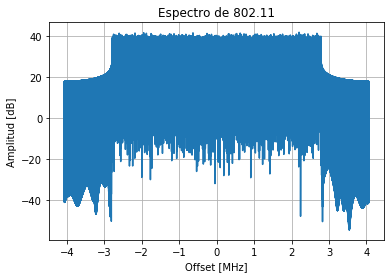

In [26]:
fcia=np.linspace(-fs/2,fs/2,len(frame))
#plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame))),fcia,20*np.log10(np.abs(np.fft.fft(frame_shapped))))
#plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame_shapped))))
plt.plot(fcia,20*np.log10(np.abs(np.fft.fft(frame))))

plt.title("Espectro de 802.11")
plt.xlabel("Offset [MHz]")
plt.ylabel("Amplitud [dB]")
plt.grid(True)

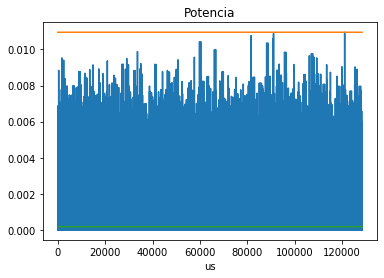

In [27]:
t_frame=np.linspace(0,len(frame)*ts,len(frame))

plt.plot(t_frame,(frame*np.conj(frame)).real,label='instantanea')
plt.plot(t_frame,np.ones(len(frame))*np.max(frame*np.conj(frame)).real,label='pico')
plt.plot(t_frame,np.ones(len(frame))*np.mean(frame*np.conj(frame)).real,label='media')
plt.title("Potencia")
plt.xlabel("us")
plt.show()

potencia_frame=frame*np.conj(frame)

In [28]:
PAR=(np.max(frame*np.conj(frame))/np.mean(frame*np.conj(frame))).real
print("La relacion entre la potencia pico y la potencia media es %.2f veces %.2f dB"%(PAR,10*np.log10(PAR)))

La relacion entre la potencia pico y la potencia media es 61.24 veces 17.87 dB


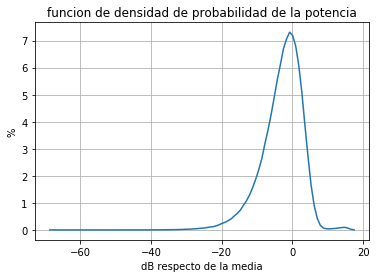

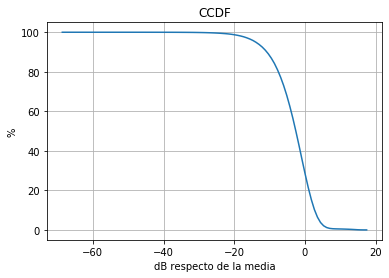

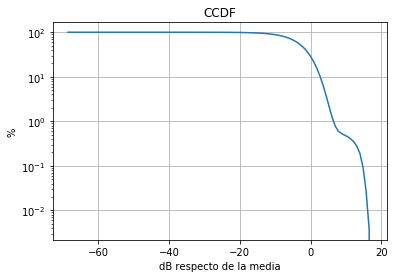

In [29]:
def CCDF(potencia):
    h = np.histogram(potencia, 100)
    CCDF=1-h[0].cumsum()
    return (h[1][:-1]+h[1][1:])/2, (CCDF/len(potencia)+1)*100

def CCDFdB(potencia):
    dB=10*np.log10(potencia.real)-10*np.log10(np.mean(potencia.real))  # 0dB sera respecto de la potencia media   
    h = np.histogram(dB, 100)
    H = np.cumsum(h[0])/len(potencia)
    CH=1-H
    return (h[1][:-1]+h[1][1:])/2,CH*100


plt.figure()
dB=10*np.log10(potencia_frame.real)-10*np.log10(np.mean(potencia_frame.real))  # 0dB sera respecto de la potencia media   
#plt.plot(dB)
#plt.figure()
h = np.histogram(dB, 100)

plt.plot((h[1][:-1]+h[1][1:])/2,(h[0]/len(dB))*100)
plt.title("funcion de densidad de probabilidad de la potencia")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

plt.figure()
x,y=CCDFdB((potencia_frame.real))
plt.plot(x,y)
plt.title("CCDF")
plt.xlabel("dB respecto de la media")
plt.ylabel("%")
plt.grid(True)

fig, ax = plt.subplots()

ax.semilogy(x,y)
ax.grid()
ax.set_title("CCDF")
ax.set_xlabel("dB respecto de la media")
ax.set_ylabel("%")
plt.show()

In [30]:
def removeCP(frame,N_of_sym):
    frame=np.reshape(frame,(N_of_sym,CP+IFFTSIZE))
    return frame[:,CP:(CP+IFFTSIZE)]
    
OFDM_RX_noCP = removeCP(frame,N_of_sym)


In [31]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)
print(np.shape(OFDM_demod))

(204, 4096)
